Import packages.

In [1]:
import os
import random
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import yaml
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from signal_autoencoder.dataloading import SeismicSignals
from signal_autoencoder.modeling import ConvRecAutoencoder

/home/paul/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/paul/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c104cuda9SetDeviceEi'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


Load embeddings.

In [2]:
embeddings = torch.load('../data/embeddings.pt', map_location=torch.device('cpu'))
embeddings = embeddings.squeeze().numpy()

print('Shape of embeddings:', embeddings.shape)

Shape of embeddings: (48669, 256)


Load dataloader for event metadata.

In [3]:
dataloader = torch.load('../data/dataloader.pth')
event_ids = np.array([f.split('_')[0] for f in dataloader.dataset.files])
df_event = pd.read_csv('../data/events.csv')
event_types = np.array([
    df_event.loc[df_event['eventID'] == int(i), 'event_type'].item()
    for i in event_ids
])
m = dataloader.dataset.mean
s = dataloader.dataset.std

In [4]:
print(m, s)

tensor([-5.1987e-06,  7.6648e-06,  7.0173e-06]) tensor([145.1290, 141.0555, 106.9961])


Visualize signal and its reconstruction.

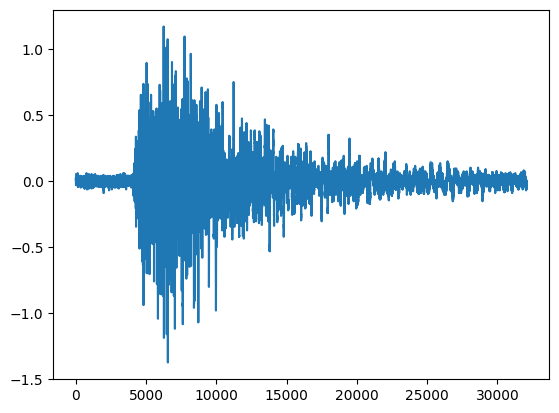

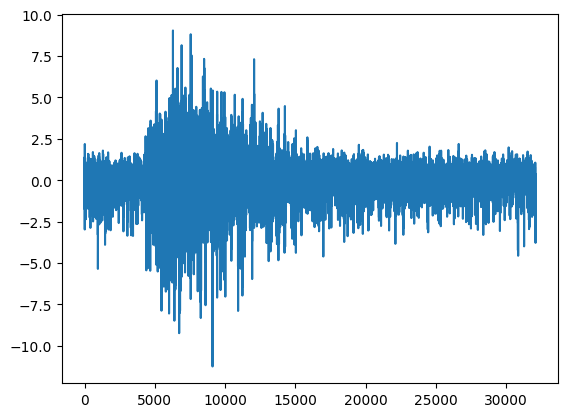

In [20]:
dataset = SeismicSignals('../data', df_event)
dataset.set_mean_and_std(m, s)

with open('../scripts/config.yml', 'r') as f:
    config = yaml.safe_load(f)

n_conv_channel_1 = config['conv_rec_net']['n_conv_channel_1']
n_conv_channel_2 = config['conv_rec_net']['n_conv_channel_2']
n_conv_channel_3 = config['conv_rec_net']['n_conv_channel_3']
lstm_hidden_size = config['conv_rec_net']['lstm_hidden_size']
n_lstm_layer = config['conv_rec_net']['n_lstm_layer']
model = ConvRecAutoencoder(3, n_conv_channel_1, n_conv_channel_2,
                           n_conv_channel_3, lstm_hidden_size,
                           n_lstm_layer)
checkpoint = torch.load('../scripts/model.pt', map_location=torch.device('cpu'))

i = random.randint(0, len(dataset))

x, _ = dataset.__getitem__(i)
with torch.no_grad():
    y = model(x[None,:,:])
    y = y.squeeze()

plt.plot(x[:,0])
plt.show()
plt.plot(y[:,0])
plt.show()

There are two types of event: earthquare, nuclear explosion.

Let's predict the event type from its signal embeddings.

In [6]:
print('Number of signals by event type:')
print('- earthquake:', len(event_ids[event_types == 'earthquake']))
print('- nuclear explosion:', len(event_ids[event_types == 'nuclear explosion']))

Number of signals by event type:
- earthquake: 48638
- nuclear explosion: 31


The data is highly imbalanced

Split events for training and test.

In [7]:
train_events, test_events = train_test_split(df_event['eventID'].values,
                                             stratify=df_event['event_type'])

is_train = np.isin(event_ids, train_events)
is_test = np.isin(event_ids, test_events)

Train a logistic regression.

In [8]:
X_train = embeddings[is_train]
X_test = embeddings[is_test]
y_train = event_types[is_train]
y_test = event_types[is_test]

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print('Accuracy:')
print('- training', lr.score(X_train, y_train))
print('- test', lr.score(X_test, y_test))
print('')
print('Test confusion matrix:')
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))

/home/paul/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy:
- training 0.7950356152465881
- test 0.8144191133170691

Test confusion matrix:
[[9681 2203]
 [   3    0]]


Visualize the logistic regression coefficients.

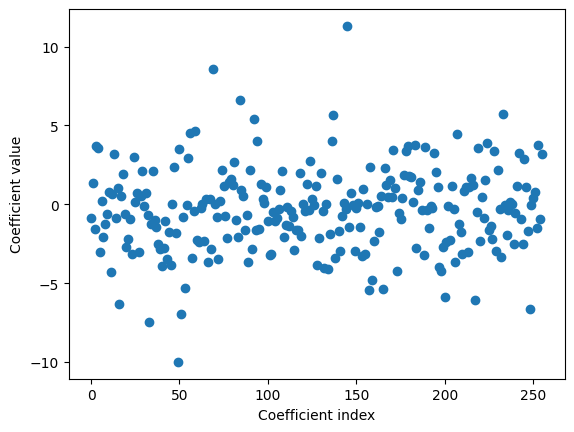

In [9]:
plt.scatter(range(len(lr.coef_.flatten())), lr.coef_)
plt.xlabel('Coefficient index')
plt.ylabel('Coefficient value')
plt.show()

Let's predict the event type using the corresponding best embedding dimension only.

In [10]:
best_coef = np.argmax(np.abs(lr.coef_))

In [11]:
embeddings_1d = embeddings[:,best_coef]
X_train = embeddings_1d[is_train].reshape(-1, 1)
X_test = embeddings_1d[is_test].reshape(-1, 1)
y_train = event_types[is_train]
y_test = event_types[is_test]

lr = LogisticRegression(class_weight='balanced')
lr.fit(X_train, y_train)
print('Accuracy:')
print('- training', lr.score(X_train, y_train))
print('- test', lr.score(X_test, y_test))
print('')
print('Test confusion matrix:')
y_pred = lr.predict(X_test)
print(confusion_matrix(y_test, y_pred))


Accuracy:
- training 0.6175303137404166
- test 0.6339698830655338

Test confusion matrix:
[[7536 4348]
 [   3    0]]
